In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.fft import fft2, ifft2, fftshift, ifftshift
import cv2
from skimage import io, color, img_as_float, img_as_ubyte, exposure, filters
from scipy.ndimage import convolve

In [2]:
import imutils
import easyocr

In [3]:
from PIL import Image, ImageEnhance
import pytesseract

In [4]:
import re
from IPython.display import Markdown

## Module 0: Image Cropped Plate And Detect car license plate

## displays the grayscale image

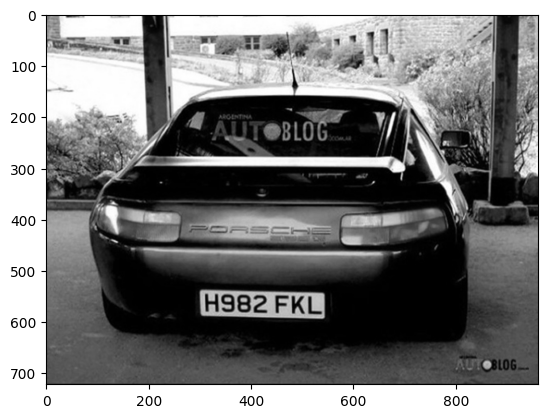

In [5]:
imgP = cv2.imread("image3.jpg")
img = imgP
img1 = imgP
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
plt.imshow(cv2.cvtColor(gray, cv2.COLOR_BGR2RGB))

 ## applies a bilateral filter to the grayscale image gray

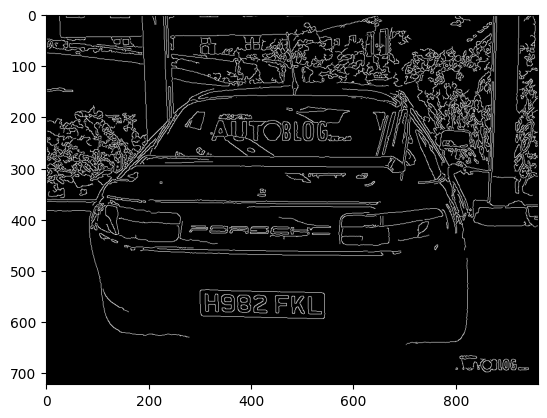

In [6]:
bfilter = cv2.bilateralFilter(gray, 11, 17, 17)
edged = cv2.Canny(bfilter, 30, 200)
plt.imshow(cv2.cvtColor(edged, cv2.COLOR_BGR2RGB))

## Find location license plate

In [7]:
keypoints = cv2.findContours(edged.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
contours = imutils.grab_contours(keypoints)
contours = sorted(contours, key=cv2.contourArea, reverse=True)[:10]

In [8]:
location = None
for contour in contours:
  approx = cv2.approxPolyDP(contour, 10, True)
  if len(approx) == 4:
    location = approx
    break
location      

array([[[300, 540]],

       [[306, 589]],

       [[543, 592]],

       [[538, 543]]], dtype=int32)

## Add Mask And Cropped Plate

In [9]:
mask = np.zeros(gray.shape, np.uint8)
new_image = cv2.drawContours(mask, [location], 0, 255, -1)
new_image = cv2.bitwise_and(img, img, mask=mask)

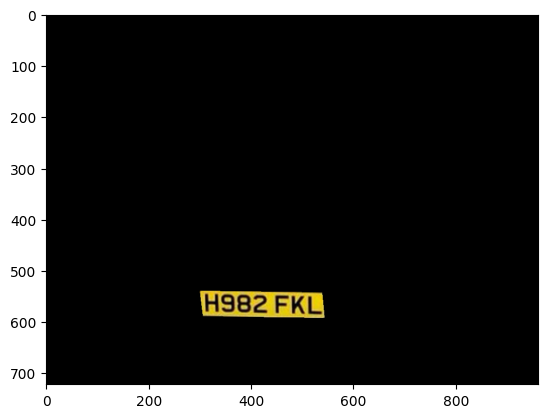

In [10]:
plt.imshow(cv2.cvtColor(new_image, cv2.COLOR_BGR2RGB))

In [11]:
(x,y) = np.where(mask==255)
(x1, y1) = (np.min(x), np.min(y))
(x2, y2) = (np.max(x), np.max(y))
cropped_image = gray[x1:x2+1, y1:y2+1]

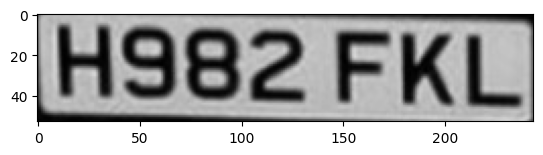

In [12]:
plt.imshow(cv2.cvtColor(cropped_image, cv2.COLOR_BGR2RGB))

## Add Filter

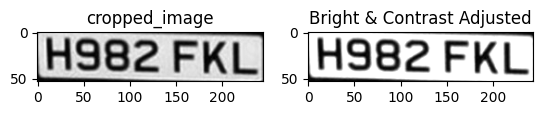

In [13]:
def adjust_brightness_contrast(cropped_image, brightness=0, contrast=0):
    # Formula: new_img = img * contrast + brightness
    return cv2.convertScaleAbs(cropped_image, alpha=contrast, beta=brightness)

# Adjust brightness and contrast
bright_img = adjust_brightness_contrast(cropped_image, brightness=50, contrast=1.2)

# Display the result
plt.subplot(1, 2, 1), plt.imshow(cropped_image, cmap='gray'), plt.title('cropped_image')
plt.subplot(1, 2, 2), plt.imshow(bright_img, cmap='gray'), plt.title('Bright & Contrast Adjusted')
plt.show()

In [14]:
# เพิ่มความคมชัดให้ภาพ
# 9: ขนาดของหน้าต่างฟิลเตอร์ (ในกรณีนี้คือ 9x9 พิกเซล)
# 75: ค่า sigmaColor สูงจะทำให้สีคล้ายกันถูกลด noise ร่วมกันได้ดีขึ้น
# 75: ค่า sigmaSpace ซึ่งกำหนดขอบเขตของพิกเซลในพื้นที่ที่ฟิลเตอร์จะทำงาน ยิ่งค่านี้สูงขึ้น การลด noise จะสามารถทำได้ในขอบเขตที่กว้างขึ้น
de_noise = cv2.bilateralFilter(bright_img, 9, 100, 100)  # ใช้ Bilateral Filter เพื่อลด noise

# เพิ่ม Contrast ด้วย PIL
pil_image = Image.fromarray(de_noise)
enhancer = ImageEnhance.Contrast(pil_image)
enhanced_image = enhancer.enhance(5)  # ปรับค่า Contrast ให้สูงขึ้น (ลองปรับค่าได้ตามต้องการ)

# แปลงกลับเป็น OpenCV เพื่อแสดงผล
final_image = cv2.cvtColor(np.array(enhanced_image), cv2.COLOR_GRAY2BGR)

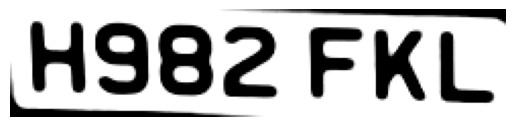

True

In [15]:
# แสดงภาพที่ถูกครอบในสี RGB
plt.imshow(cv2.cvtColor(final_image, cv2.COLOR_BGR2RGB))
plt.axis('off')  # ซ่อนแกน x และ y
plt.show()
cv2.imwrite('cropped_image_test.png', final_image)

## pytesseract text

In [16]:
image_path = "cropped_image_test.png"  # กำหนด path ของรูปภาพที่ต้องการอ่าน
image = Image.open(image_path)

# ใช้ Tesseract เพื่อดึงข้อความจากภาพ
text = pytesseract.image_to_string(image, config='--psm 8').strip()
pytesseract_text = re.sub(r'[^A-Za-z0-9]', '', text)
pytesseract_text

'HS982FKL'

## Easyocr text

In [17]:
reader = easyocr.Reader(['en'])
result = reader.readtext(final_image)
easyocr_text = result[0][-2]
result

Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


[([[0, 0], [244, 0], [244, 53], [0, 53]],
  'H98z FKL',
  np.float64(0.8778761069849482))]

## Result By Pytesseract text

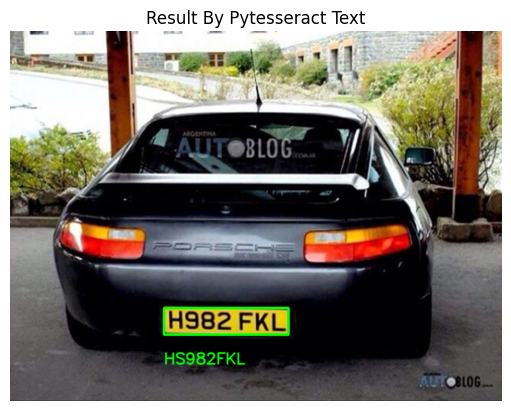

In [18]:
font = cv2.FONT_HERSHEY_SIMPLEX

# สำหรับผลลัพธ์แรก (pytesseract_text)
img_pytesseract = img.copy()  # สร้างสำเนาสำหรับ pytesseract_text
res_pytesseract = cv2.putText(
    img_pytesseract, 
    text=pytesseract_text, 
    org=(approx[0][0][0], approx[1][0][1] + 60),  # ตำแหน่งที่จะแสดงข้อความ
    fontFace=font, 
    fontScale=1, 
    color=(0, 255, 0), 
    thickness=2, 
    lineType=cv2.LINE_AA
)
res_pytesseract = cv2.rectangle(img_pytesseract, tuple(approx[0][0]), tuple(approx[2][0]), (0, 255, 0), 3)

# แสดงผลภาพที่มีข้อความ pytesseract_text
plt.title("Result By Pytesseract Text")
plt.imshow(cv2.cvtColor(res_pytesseract, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

In [19]:
Markdown(f"<span style='font-size:50px;'>**{pytesseract_text.upper()}**</span>")

<span style='font-size:50px;'>**HS982FKL**</span>

## Result By Easyocr text

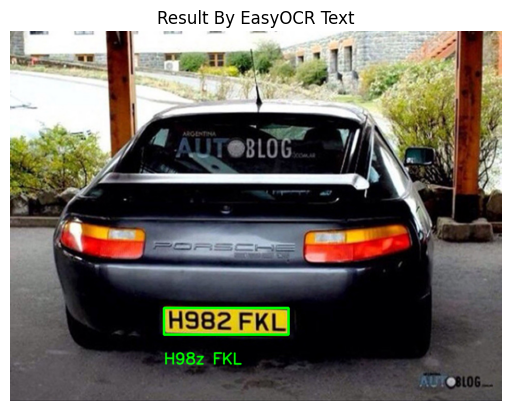

In [20]:
img_easyocr = img.copy()  # สร้างสำเนาสำหรับ easyocr_text
res_easyocr = cv2.putText(
    img_easyocr, 
    text=easyocr_text, 
    org=(approx[0][0][0], approx[1][0][1] + 60),  # ตำแหน่งที่จะแสดงข้อความ
    fontFace=font, 
    fontScale=1, 
    color=(0, 255, 0), 
    thickness=2, 
    lineType=cv2.LINE_AA
)
res_easyocr = cv2.rectangle(img_easyocr, tuple(approx[0][0]), tuple(approx[2][0]), (0, 255, 0), 3)

# แสดงผลภาพที่มีข้อความ easyocr_text
plt.title("Result By EasyOCR Text")
plt.imshow(cv2.cvtColor(res_easyocr, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

In [21]:
Markdown(f"<span style='font-size:50px;'>**{easyocr_text.upper()}**</span>")

<span style='font-size:50px;'>**H98Z FKL**</span>